In [1]:
# Import necessary libraries
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from pselia.config_elia import settings, load_processed_data_path
from pselia.utils import load_freq_axis
from sys import float_info
EPS = float_info.epsilon

/home/yacine/Documents/PhD/Code/GitProject/PBSHM_mdof


In [115]:

database_processed_path = load_processed_data_path('SETTINGS1')
freq = load_freq_axis(database_processed_path)


In [116]:
from pselia.training.datamodule import CreateTransformer
transformer = CreateTransformer(database_processed_path, freq,freq_min=0,freq_max=40)
psd_tf = transformer.transform_psd
freq_new = transformer.new_freq

In [117]:
class VirtualAnomaly:
    def __init__(self,freq_axis,length):
        self.freq_axis = freq_axis
        self.length = length
    
    def construct_nodge(self,f_oi,amp):
        hann_len = np.sum(np.abs(self.freq_axis-f_oi)<=self.length/2)
        hann = 1-np.hanning(hann_len)*amp
        window = np.ones(self.freq_axis.shape)
        window[np.abs(self.freq_axis-f_oi)<=self.length/2] = hann
        return window
    
    def add_notch(self,psd,window):
        if psd.ndim == 1:
            psd = psd.reshape(1,-1)
        log_psd = np.log(psd)
        #  normalize the psd  
        # let's compute the min and max when frequency is between 0 and 50 Hz
        min_psd = np.min(log_psd)
        max_psd = np.max(log_psd)
        log_psd_n =  (log_psd  - min_psd) / (2*(max_psd - min_psd))

        log_psd_n_aff =log_psd_n+ (1- window)
        #clip the psd to be between 0 and 1
        # then unnormalize the psd
        #log_psd_n_aff = log_psd_n_aff.clip(0+EPS,1-EPS) 
        psd_unnorm_aff = (log_psd_n_aff) * 2*(max_psd - min_psd) + min_psd 

        res = np.exp(psd_unnorm_aff)
        return res
    def affect_psd(self,psd,aff_f, aff_amp):
        window = self.construct_nodge(aff_f,aff_amp)
        psd_res = self.add_notch(psd,window)
        return psd_res

In [121]:
database_processed_path = load_processed_data_path('SETTINGS1')
conn = sqlite3.connect(database_processed_path)
c = conn.cursor()
c.execute("""SELECT PSD FROM processed_data WHERE date_time = '2022-04-14 22:50:00'
""")
psds = c.fetchall()
psds = np.array([np.frombuffer(psd, dtype=np.float64) for psd, in psds])
psds

array([[1.50642136e-03, 7.78226309e-03, 6.47794672e-03, ...,
        9.23353128e-04, 5.43052116e-04, 1.37647470e-02],
       [4.73247323e-03, 2.38830431e-02, 1.61790805e-02, ...,
        8.30542087e-04, 5.00570443e-04, 3.38446144e-03],
       [1.42828256e-03, 7.84511695e-03, 5.57165156e-03, ...,
        3.59107229e-04, 3.94823835e-04, 7.41538645e-03],
       ...,
       [8.81083582e-04, 4.90838762e-03, 4.09175641e-03, ...,
        4.73184518e-04, 4.14387118e-04, 5.50014566e-03],
       [5.65934362e-03, 3.45132216e-02, 2.66871747e-02, ...,
        1.04191782e-03, 1.28070376e-03, 3.02810811e-02],
       [7.20879545e-05, 2.10782453e-04, 1.45259750e-04, ...,
        1.18348686e-05, 1.23968870e-05, 2.38204150e-04]])

In [112]:
vas = VirtualAnomaly(freq,1)


In [113]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Function to update the plot
def update_plot(param1, param2,param3):
    psd = psds[param3]
    x = freq
    y1 = psd
    x_nn = freq_new
    y2 = vas.affect_psd(psd,param1,param2)
    fig,ax = plt.subplots(ncols=2,figsize=(10, 4))
    ax[0].semilogy(x,y1.T )
    ax[0].semilogy(x, y2.T)
    all_y = np.vstack((y1, y2))
    ylim_lower = np.min(all_y) * 0.9  # 10% lower than the min
    ylim_upper = np.max(all_y) * 1.1  # 10% higher than the max

    y1_nn = psd_tf(y1)
    y2_nn = psd_tf(y2)
    ax[1].plot(y1_nn.T)
    ax[1].plot(y2_nn.T) 
    ax[0].set_ylim(ylim_lower, ylim_upper)
    plt.show()

# Create widgets for interaction
param1_slider = widgets.FloatSlider(value=4.8, min=0, max=30, step=1, description='Param1:')
param2_slider = widgets.FloatSlider(value=0, min=-0.5, max=1, step=0.1, description='Param2:')
param3_slider = widgets.IntSlider(value=0, min=0, max=12, step=1, description='Param3:')

# Display widgets
widgets.interactive(update_plot, param1=param1_slider, param2=param2_slider,param3=param3_slider)


interactive(children=(FloatSlider(value=4.8, description='Param1:', max=30.0, step=1.0), FloatSlider(value=0.0…

In [68]:
from tqdm import tqdm
max_ = 0
aff_f_grid = np.arange(1,30,0.39)
aff_amp_grid = np.arange(-0.5,0.55,0.05)

prog = tqdm(total=len(aff_amp_grid), desc='Progress', position=0, leave=True)
for amp in aff_amp_grid:
    affected = vas.affect_psd(psds, 4.8,amp)
    affected_nn = psd_tf(affected)
    max_ = max(max_,np.max(affected_nn))
    prog.update(1)
    prog.set_postfix({'max':max_})
        
prog.close()



Progress: 100%|██████████| 21/21 [00:17<00:00,  1.20it/s, max=1.4] 


In [51]:
max_

1.6338568853944728

In [104]:
from pselia.config_elia import load_processed_data_path_vas
database_processed_path = load_processed_data_path_vas('SETTINGS1')
conn = sqlite3.connect(database_processed_path)
c = conn.cursor()
c.execute("""SELECT PSD,aff_f,aff_amp FROM VAS_NOTCH WHERE date_time = 
          '2022-04-20 14:25:00'""")
all_data = c.fetchall() 
psds = np.array([np.frombuffer(psd, dtype=np.float64) for psd, f_aff, amp_aff in all_data])
f_aff = np.array([f_aff for psd, f_aff, amp_aff in all_data])
amp_aff = np.array([amp_aff for psd, f_aff, amp_aff in all_data])




In [106]:
np.max(psds)

9.739703105764202e+145

Text(0.5, 1.0, 'aff2.0amp-0.5')

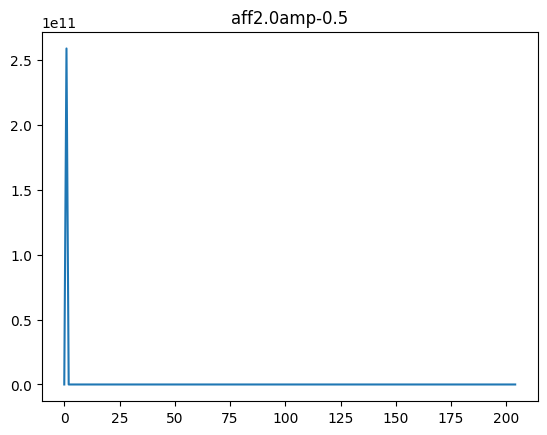

In [105]:
plt.plot(psds[0])
plt.title('aff'+str(f_aff[0])+'amp'+str(amp_aff[0]))

In [101]:
from pselia.config_elia import load_processed_data_path
database_processed_path = load_processed_data_path('SETTINGS1')
conn = sqlite3.connect(database_processed_path)
c = conn.cursor()
c.execute("""SELECT PSD FROM processed_data WHERE date_time ='2022-04-20 14:25:00'""")
psds = c.fetchall()
psds = np.array([np.frombuffer(psd, dtype=np.float64) for psd, in psds])


len(psds)

12

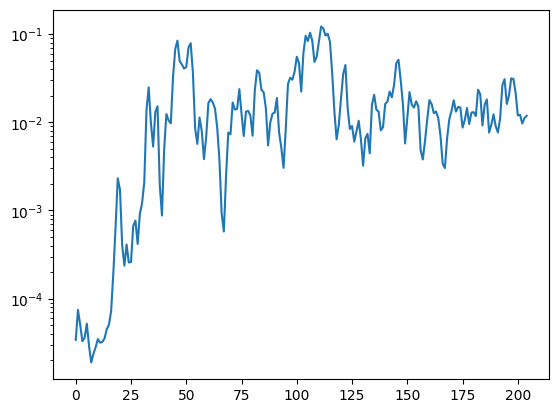

In [102]:
plt.semilogy(psds[0])

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Function to update the plot
def update_plot(param1, param2,param3):
    psd = psds[param3]
    x = freq
    y1 = psd
    x_nn = freq_new
    y2 = vas.affect_psd(psd,param1,param2)
    fig,ax = plt.subplots(ncols=2,figsize=(10, 4))
    ax[0].semilogy(x,y1.T )
    ax[0].semilogy(x, y2.T)
    all_y = np.vstack((y1, y2))
    ylim_lower = np.min(all_y) * 0.9  # 10% lower than the min
    ylim_upper = np.max(all_y) * 1.1  # 10% higher than the max

    y1_nn = psd_tf(y1)
    y2_nn = psd_tf(y2)
    ax[1].plot(y1_nn.T)
    ax[1].plot(y2_nn.T) 
    ax[0].set_ylim(ylim_lower, ylim_upper)
    plt.show()

# Create widgets for interaction
param1_slider = widgets.FloatSlider(value=4.8, min=0, max=30, step=1, description='Param1:')
param2_slider = widgets.FloatSlider(value=0, min=-0.5, max=1, step=0.1, description='Param2:')
param3_slider = widgets.IntSlider(value=0, min=0, max=12, step=1, description='Param3:')

# Display widgets
widgets.interactive(update_plot, param1=param1_slider, param2=param2_slider,param3=param3_slider)


interactive(children=(FloatSlider(value=4.8, description='Param1:', max=30.0, step=1.0), FloatSlider(value=0.0…